In [2]:
import os
import xarray as xr
import pandas as pd
import netCDF4 as nc
from pathlib import Path
import matplotlib.pyplot as plt
import gc
import os 
from os.path import exists
import dask_labextension
import numpy as np
import xarray as xr
import regionmask
from xmip.regionmask import merged_mask
import xesmf
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
import src
from src import *
import gsw, xwmt, xgcm
import cmocean.cm as cm

In [97]:
def get_sigma2(ds, keep_vars = False): 
    ds['p'] = xr.apply_ufunc(
        gsw.p_from_z, -ds.z, ds.lat, 0, 0, dask="parallelized"
    )


    ds['sa'] = xr.apply_ufunc(
        gsw.SA_from_SP,
        ds.so,
        ds.p,
        ds.lon,
        ds.lat,
        dask="parallelized",
    )
    ds['ct'] = xr.apply_ufunc(
        gsw.CT_from_t,
        ds.sa,
        ds.thetao,
        ds.p,
        dask="parallelized"
    )

    ds['sigma2'] = xr.apply_ufunc(
        gsw.sigma2,
        ds.sa,
        ds.ct,
        dask="parallelized"
    )
    if keep_vars: 
        return ds
    else: 
        return ds.drop_vars(["p", "sa", "ct"])
    

In [3]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='125GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0',
    log_directory = rootdir + "/slurmscratch")
print(cluster.job_script())
cluster.scale(jobs=5)
from dask.distributed import Client
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch/dask-worker-%J.out
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=117G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.185:39694 --name dummy-name --nthreads 36 --memory-limit 116.42GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.185:39694,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
import cmocean

In [5]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [134]:
def read_CM4X(fname): 
    ds = xr.open_mfdataset(
        datadir(f"model/yearly_output_0.25deg/{fname}"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1, "time":-1, "depth":2},
        engine="zarr")
    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"geolat":"lat", "geolon":"lon"})
    ds = approximate_z(ds)
    ds = ds.where(ds.thkcello > 1e-9)
    return ds
    
def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [135]:
CM4Xp125_historical = read_CM4X("CM4Xp125_historical_transient_tracers.zarr")
CM4Xp125_ctrl = read_CM4X("CM4Xp125_piControl_transient_tracers.zarr")
CM4Xp125_ctrl = CM4Xp125_ctrl.isel(year = slice(None, 165))
CM4Xp125_ctrl.coords['year'] = CM4Xp125_historical.coords['year'].values

/tmp/ipykernel_265487/1984162636.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(["lat", "lon"])
/tmp/ipykernel_265487/1984162636.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(["lat", "lon"])


### Taking time average between 2010 - 2014

In [136]:
CM4Xp125_ctrl = CM4Xp125_ctrl.sel(year = slice(2010, None)).mean("year")
CM4Xp125_historical = CM4Xp125_historical.sel(year = slice(2010, None)).mean("year")

### Defining Pacific Ocean Mask

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


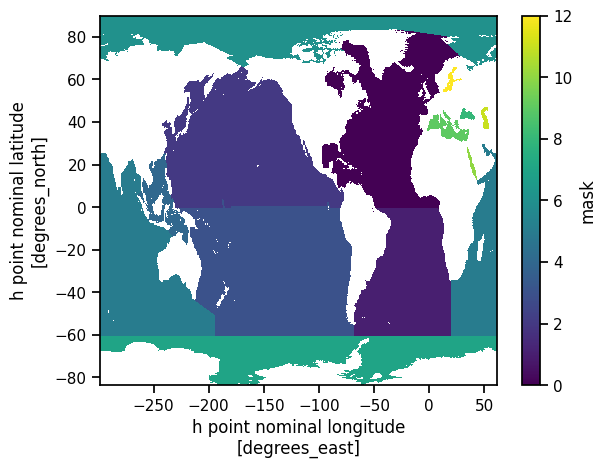

In [137]:
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
mask = merged_mask(basins,CM4Xp125_ctrl, lon_name = "xh", lat_name = "yh").compute()
mask.plot()

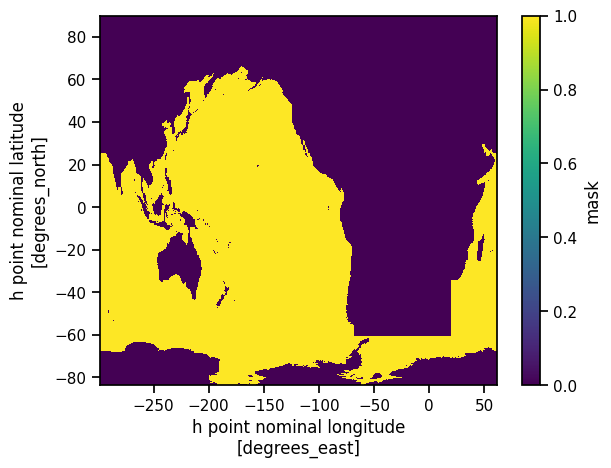

In [138]:
PAC_mask =np.logical_or(np.logical_or(mask == 2, mask==3),mask==4) #Pacific + marginal seas
PAC_mask =np.logical_or(PAC_mask, mask == 7) #add southern ocean
PAC_mask =np.logical_or(PAC_mask, mask == 5) #add Indian ocean
PAC_mask.plot()

In [139]:
PAC_mask = CM4Xp125_historical.lat != np.nan

In [140]:
CM4Xp125_hist_PAC = get_sigma2(CM4Xp125_historical.where(PAC_mask)).compute()
CM4Xp125_ctrl_PAC = get_sigma2(CM4Xp125_ctrl.where(PAC_mask)).compute()

In [141]:
def zonal_average(ds, var):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds[var] * weights).sum(["xh"]) / weights.sum(["xh"])
    return weighted_ds

def get_zonal_average_dataset(ds, var = "sigma2"): 
    ds_zonal = zonal_average(ds, var).compute().rename(var)
    ds_zonal["z"] = zonal_average(ds, "z").compute()
    ds_zonal = ds_zonal.to_dataset()
    ds_zonal["lat"] = zonal_average(ds, "lat").compute()
    ds_zonal = interpolate_section(ds_zonal, np.arange(100, 7000, 50), interp_coord = "z", iterate_coord = "yh")
    gc.collect()
    return ds_zonal
    

In [142]:
zonal_PAC_hist =  get_zonal_average_dataset(CM4Xp125_hist_PAC, var = "cfc11")
zonal_PAC_hist = xr.merge([zonal_PAC_hist[["cfc11"]], 
                          get_zonal_average_dataset(CM4Xp125_hist_PAC, var = "sigma2")])
zonal_PAC_hist = zonal_PAC_hist.where(zonal_PAC_hist.lat < 0)

In [143]:
zonal_PAC_ctrl =  get_zonal_average_dataset(CM4Xp125_ctrl_PAC, var = "cfc11")
zonal_PAC_ctrl = xr.merge([zonal_PAC_ctrl[["cfc11"]], 
                          get_zonal_average_dataset(CM4Xp125_ctrl_PAC, var = "sigma2")])
zonal_PAC_ctrl = zonal_PAC_ctrl.where(zonal_PAC_hist.lat < 0)

In [144]:
difference = (zonal_PAC_hist.cfc11 - zonal_PAC_ctrl.cfc11).rename("cfc11_difference")
difference = difference.to_dataset()
difference["ctrl_cfc11"] = zonal_PAC_ctrl["cfc11"]
difference["hist_cfc11"] = zonal_PAC_hist["cfc11"]

difference["ctrl_sigma"] = zonal_PAC_ctrl["sigma2"]
difference["hist_sigma"] = zonal_PAC_hist["sigma2"]

(-80.0, 0.0)

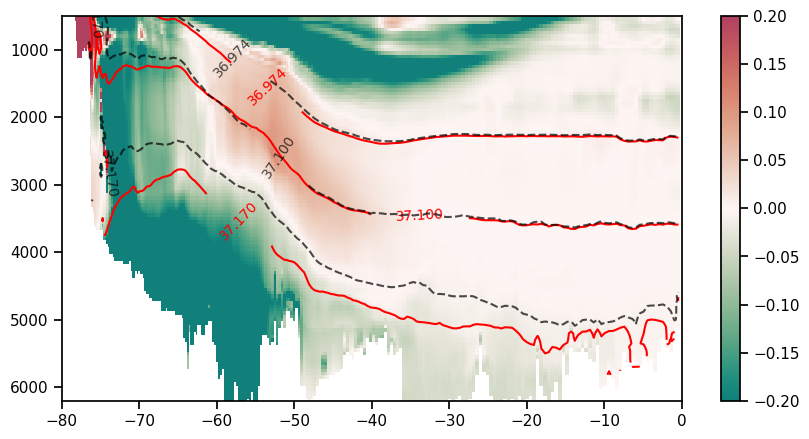

In [145]:
import seaborn as sns
sns.set_context("notebook")
cfc11_levels = np.linspace(-0.2, 0.2, 11)
siglevels = np.arange(36.2, 37.4, .2) 
siglevels = 1.0 * np.append(siglevels, [37.11, 37.17])
siglevels = np.sort(siglevels)

siglevels = np.array([36.974, 37.1, 37.17])

newcmap = cmocean.tools.crop_by_percent(cmocean.cm.curl, 40)

fig, ax = plt.subplots(figsize = (10, 5))
cb = ax.pcolormesh(difference.yh, difference.z, difference["cfc11_difference"] * variable_kwargs["cfc11"]["conversion"], 
            vmin = -0.2, vmax = 0.2, cmap = newcmap)

CS = ax.contour(difference.yh, difference.z, difference.ctrl_sigma, levels = siglevels, colors = "black", linestyles='dashed', zorder = 10, alpha = 0.7)
plt.clabel(CS, inline=1, fontsize=10,inline_spacing=5)

CS = ax.contour(difference.yh, difference.z, difference.hist_sigma, levels = siglevels, colors = "red")
plt.clabel(CS, inline=1, fontsize=10,inline_spacing=5)

fig.colorbar(cb)
ax.set_ylim(500, 6200)
ax.invert_yaxis()
ax.set_xlim(-80, 0)

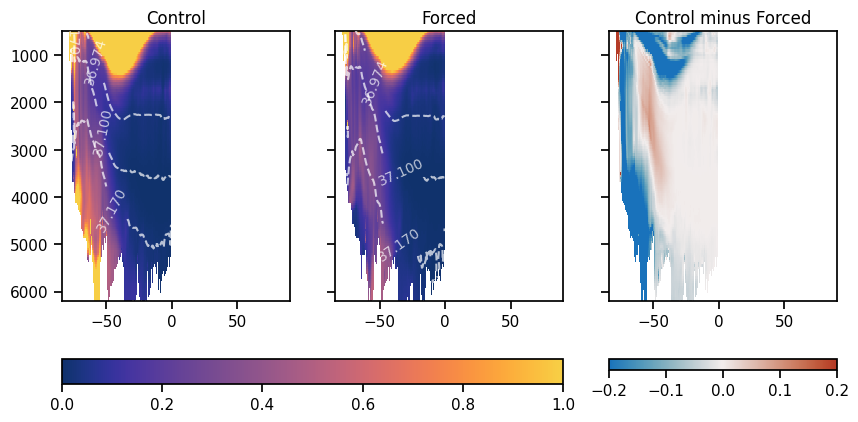

In [146]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5), sharey = True)

newcmap = cmocean.tools.crop_by_percent(cmocean.cm.thermal, 20)
newcmapd = cmocean.tools.crop_by_percent(cmocean.cm.balance, 40)

ax[0].set_title("Control")
cb = ax[0].pcolormesh(difference.yh, difference.z, difference["ctrl_cfc11"] * variable_kwargs["cfc11"]["conversion"], 
            vmin = 0, vmax = 1.0, cmap = newcmap)
CS = ax[0].contour(difference.yh, difference.z, difference.ctrl_sigma, levels = siglevels, colors = "white", linestyles='dashed', zorder = 10, alpha = 0.7)
plt.clabel(CS, inline=1, fontsize=10,inline_spacing=3)

ax[1].set_title("Forced")

cb = ax[1].pcolormesh(difference.yh, difference.z, difference["hist_cfc11"] * variable_kwargs["cfc11"]["conversion"], 
            vmin = 0.0, vmax = 1.0, cmap = newcmap)

fig.colorbar(cb, ax = ax[0:2], orientation = "horizontal")

CS = ax[1].contour(difference.yh, difference.z, difference.hist_sigma, levels = siglevels, colors = "white", linestyles='dashed', zorder = 10, alpha = 0.7)
plt.clabel(CS, inline=1, fontsize=10,inline_spacing=3)

ax[2].set_title("Control minus Forced")

cb = ax[2].pcolormesh(difference.yh, difference.z, difference["cfc11_difference"] * variable_kwargs["cfc11"]["conversion"], 
            vmin = -0.2, vmax = 0.2, cmap = newcmapd)
fig.colorbar(cb, ax = ax[2], orientation = "horizontal")

[a.set_ylim(500, 6200) for a in ax]
ax[0].invert_yaxis()
# [a.set_xlim(-80, 0) for a in ax]

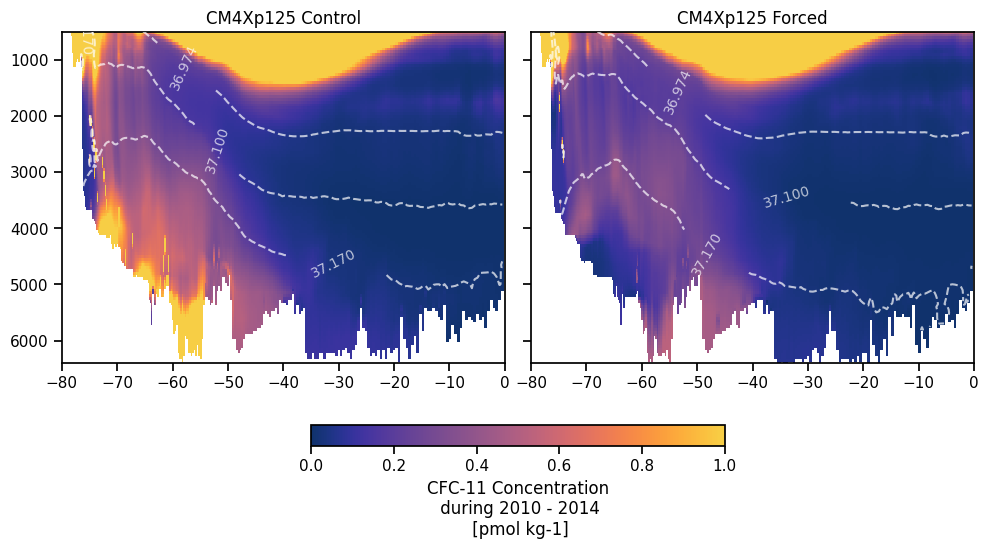

In [148]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5), sharey = True)

newcmap = cmocean.tools.crop_by_percent(cmocean.cm.thermal, 20)
newcmapd = cmocean.tools.crop_by_percent(cmocean.cm.balance, 40)

ax[0].set_title("CM4Xp125 Control")
cb = ax[0].pcolormesh(difference.yh, difference.z, difference["ctrl_cfc11"] * variable_kwargs["cfc11"]["conversion"], 
            vmin = 0, vmax = 1.0, cmap = newcmap)
CS = ax[0].contour(difference.yh, difference.z, difference.ctrl_sigma, levels = siglevels, colors = "white", linestyles='dashed', zorder = 10, alpha = 0.7)
plt.clabel(CS, inline=1, fontsize=10,inline_spacing=2)

ax[1].set_title("CM4Xp125 Forced")

cb = ax[1].pcolormesh(difference.yh, difference.z, difference["hist_cfc11"] * variable_kwargs["cfc11"]["conversion"], 
            vmin = 0.0, vmax = 1.0, cmap = newcmap)

CS = ax[1].contour(difference.yh, difference.z, difference.hist_sigma, levels = siglevels, colors = "white", linestyles='dashed', zorder = 10, alpha = 0.7)
plt.clabel(CS, inline=1, fontsize=10,inline_spacing=2)
fig.tight_layout()
fig.colorbar(cb, ax = ax[0:2], label = f"CFC-11 Concentration\n during 2010 - 2014\n [{variable_kwargs["cfc11"]["units"]}]", 
             orientation = "horizontal", 
             fraction = 0.05)
[a.set_ylim(500, 6400) for a in ax]
[a.set_xlim(-80, -0) for a in ax]
ax[0].invert_yaxis()

fig.savefig(plotsdir("supp_paper_figures/CM4X_CFC11_zonal.png"), bbox_inches = "tight", dpi = 200)